In [1]:
import numpy as np
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats
import sklearn
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import mne
from mne.decoding import CSP
from mne import Epochs
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle 
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/victoria/icn/icn_m1')
import os

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

from scipy import stats
from collections import OrderedDict
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from bayes_opt import BayesianOptimization
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import gc
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor

space_LM = [Real(0, 1, "uniform", name='alpha'),Real(0, 1, "uniform", name='l1_ratio')]

def optimize_enet(x,y):
    scaler = StandardScaler()
    reg=ElasticNet(max_iter=1000)
    clf = make_pipeline(scaler, reg)

      
    @use_named_args(space_LM)
    def objective(**params):
        reg.set_params(**params)
        cval = cross_val_score(clf, x, y, scoring='r2', cv=3)
        cval[np.where(cval < 0)[0]] = 0
    
        return -cval.mean()

    res_gp = gp_minimize(objective, space_LM, n_calls=20, random_state=0)
    return res_gp

# subjects to analyze
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
PATH_BASE = r"C:\Users\ICN_admin\Documents\ECOGVSTN\data"


In [2]:
def get_res(PATH_, all_=True, best_Tr=False, SPOC_ = False, log_=False):
    """
    Given the resp. Path for LM/XGB/NN based on single channel estimaton; 
    return rather all, oder just the best CV test or test(best train) performances 
    returns dict(ECOG CON, ECOG IPS; STN CON, STN IPS)
    """
    res_files = os.listdir(PATH_)
    res_ = {}; # ECOG CON, ECOG IPS; STN CON, STN IPS
    for loc in ["ECOG", "STN"]:
        for lat in ["CON", "IPS"]:
            patients_ = []
            for sub in subjects:
                files = [f for f in res_files if (sub in f) and (loc in f)]
                max_ = []; tr_ = []; te_ = []
                for file in files: # Sess right or left
                    
                    if log_ is True: print(file)
                    if all_ is True:
                        max_.append(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat])
                    else:
                        if SPOC_ is False:
                            max_.append(np.max(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat])
                            te_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat])

                        else:
                            max_.append(np.mean(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat]))
                            te_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat]))

                if all_ is True: 
                    patients_.append(np.concatenate(max_).ravel())
                else:
                    if best_Tr is True:
                        if SPOC_ is False:
                            patients_.append(np.concatenate(te_).ravel()[np.argmax(np.concatenate(tr_).ravel())])
                        else:
                            patients_.append(np.ravel(te_)[np.argmax(np.ravel(tr_))])
                    else:
                        patients_.append(np.max(max_))
            res_[loc+"_"+lat] = np.concatenate(patients_).ravel() if all_ is True else patients_
    return res_

In [4]:
df.to_csv("Figure3.csv")

In [4]:
def get_the_line(loc = "ECOG", lat = "CON"):
    add_ = []
    for method in ['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB']:
        add_.append(df[(df["loc"] == loc) & (df["method"] == method) & (df["lat"] == lat)][r"$R^2$"].median())
    return add_

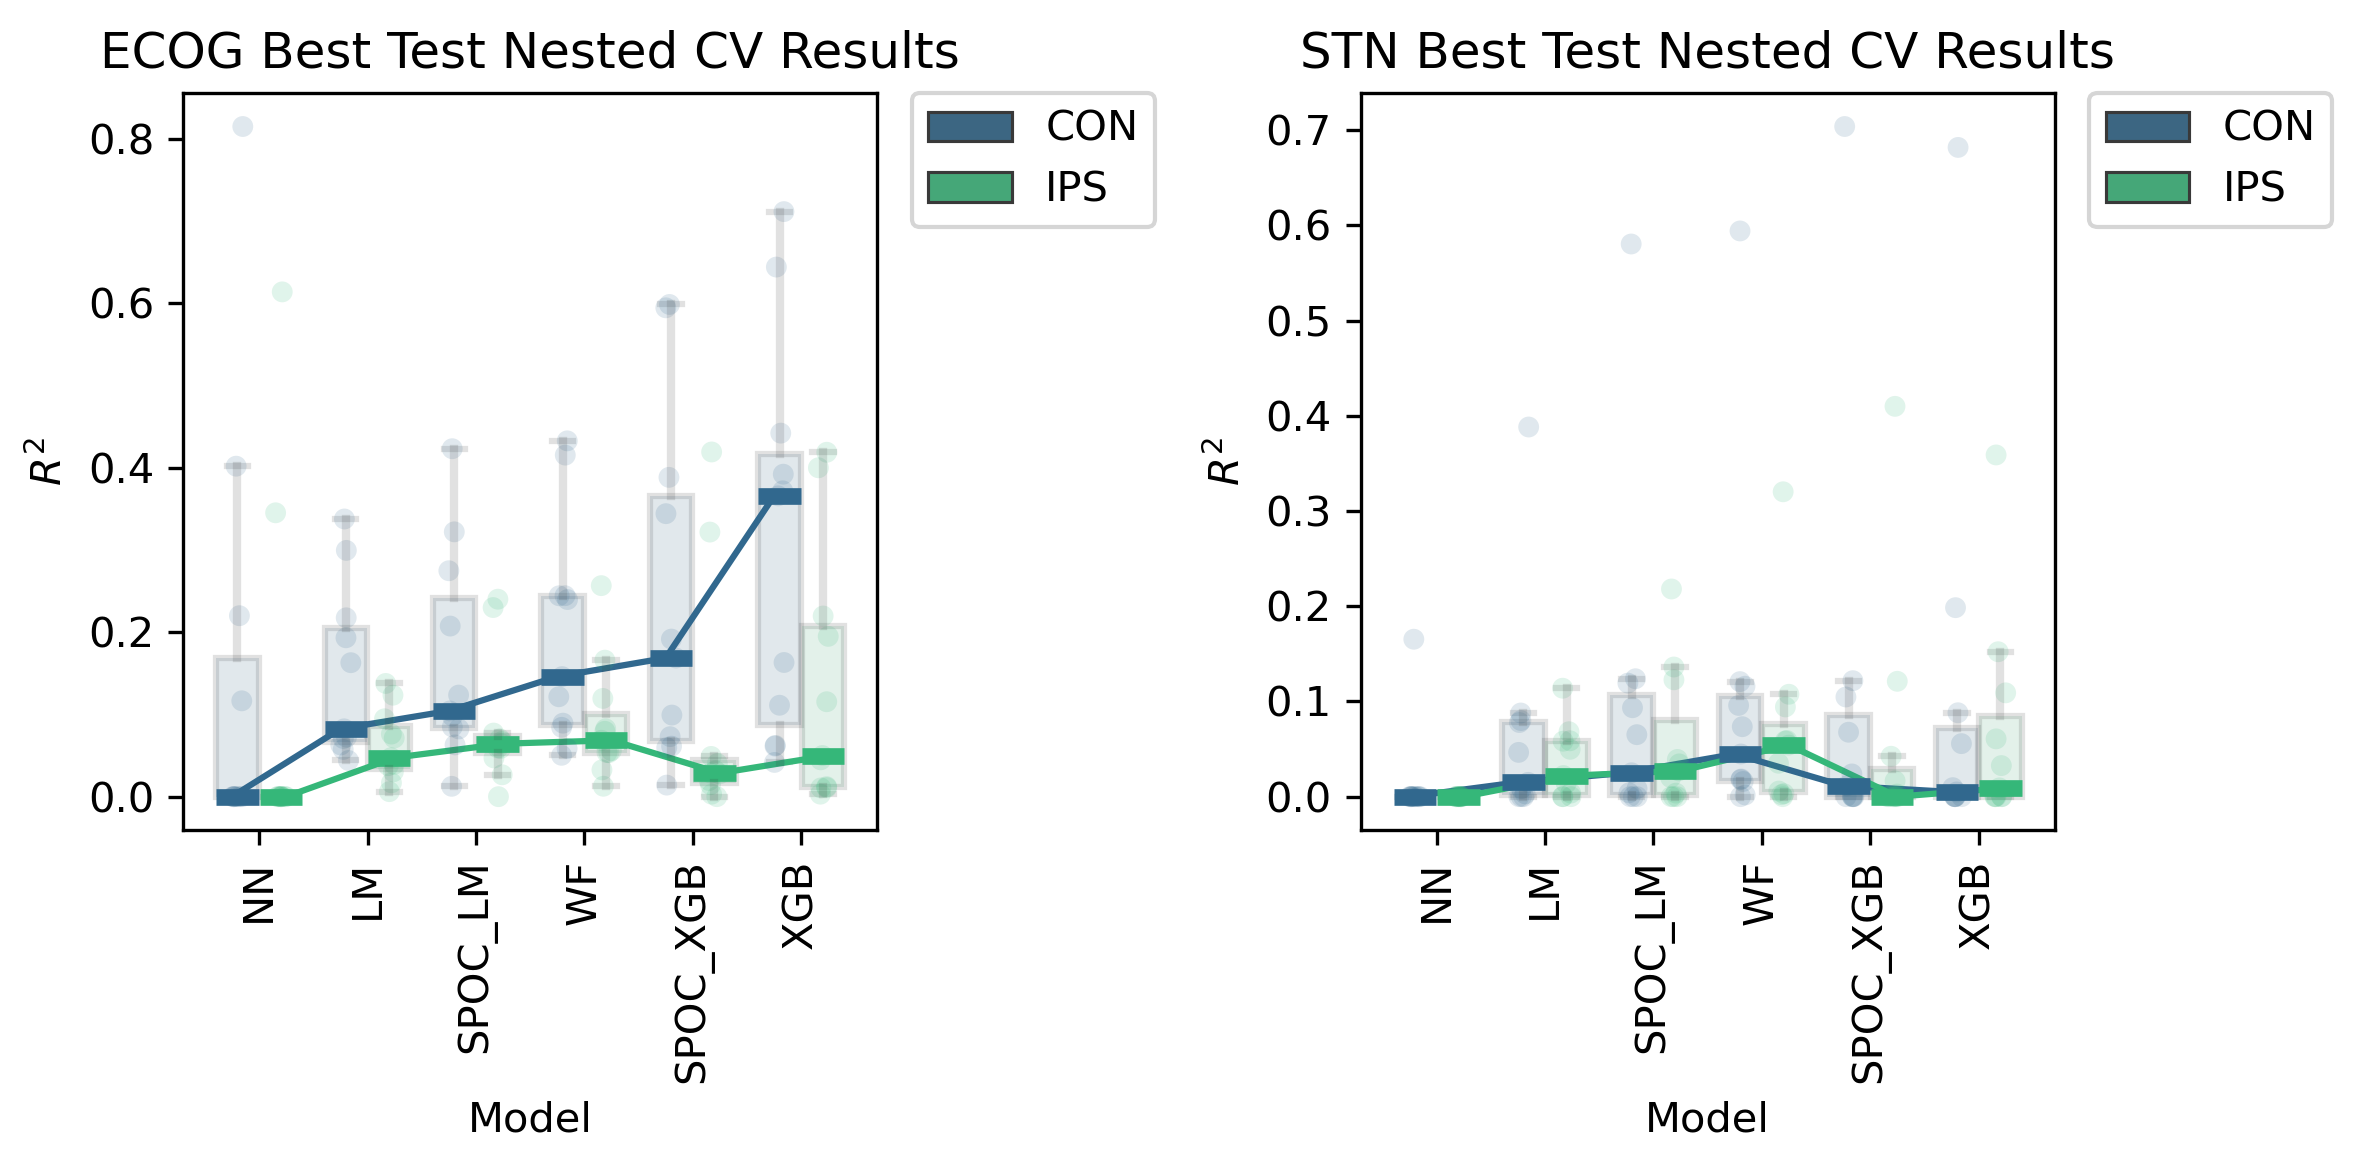

In [5]:
alpha_box = 0.15
plt.figure(figsize=(8,4), dpi=300)
plt.subplot(121)
sb.boxplot(x="method", y=r"$R^2$", hue="lat", order=['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB'], 
           data=df[df["loc"] == "ECOG"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=4, color="gray", alpha=0.0124))
    
ax = sb.stripplot(x="method", y=r"$R^2$", hue="lat", order=['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB'], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5, alpha=alpha_box)
plt.xticks(np.arange(0, 6,1), ['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB'], rotation=90)

hue_colors = sb.color_palette("viridis", df["lat"].unique().shape[0])

plt.plot(np.array([0,1,2, 3,4,5])-0.25, get_the_line("ECOG", "CON"), c=hue_colors[0])
plt.plot(np.array([0,1,2, 3,4,5])+0.25, get_the_line("ECOG", "IPS"), c=hue_colors[1])

plt.xlabel("Model")
# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ECOG Best Test Nested CV Results")




for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))

switch_ = 0
for line in ax.lines:
    if line.get_alpha() == 0.0124:
        
        line.set_color(hue_colors[switch_])
        switch_ += 1
        
        if switch_ >= len(hue_colors):
            switch_ = 0
            
        line.set_alpha(1)
        
plt.subplot(122)
sb.boxplot(x="method", y=r"$R^2$", hue="lat", order=['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB'], 
           data=df[df["loc"] == "STN"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=4, color="gray", alpha=0.0124))
    
ax = sb.stripplot(x="method", y=r"$R^2$", hue="lat", order=['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB'], 
             data=df[df["loc"] == "STN"],palette="viridis", dodge=True, s=5, alpha=alpha_box)
plt.xticks(np.arange(0, 6,1), ['NN', 'LM', 'SPOC_LM', 'WF', 'SPOC_XGB', 'XGB'], rotation=90)
plt.xlabel("Model")
# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STN Best Test Nested CV Results")

plt.plot(np.array([0,1,2, 3,4,5])-0.25, get_the_line("STN", "CON"), c=hue_colors[0])
plt.plot(np.array([0,1,2, 3,4,5])+0.25, get_the_line("STN", "IPS"), c=hue_colors[1])


hue_colors = sb.color_palette("viridis", df["lat"].unique().shape[0])

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))

switch_ = 0
for line in ax.lines:
    if line.get_alpha() == 0.0124:
        
        line.set_color(hue_colors[switch_])
        switch_ += 1
        
        if switch_ >= len(hue_colors):
            switch_ = 0
            
        line.set_alpha(1)
plt.tight_layout()
plt.savefig("Figure 3.pdf", bbox_inches='tight', dpi=300)
